In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime, timezone, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats as stats

In [84]:
# loading files
file1_locations = 'Jan20 Rail Stops and Geocoded Locations.txt'
file2_data = 'Light Rail and Commuter Rail Data Dec 1 2018 to Nov 2019.txt'

In [85]:
locations = pd.read_csv(file1_locations,
                       header=0,
                       sep=';')
locations.head(10)
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 4 columns):
STOPABBR     154 non-null int64
STOPNAME     154 non-null object
LATITUDE     154 non-null float64
LONGITUDE    154 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.9+ KB


In [86]:
trains = pd.read_csv(file2_data,
                       header=0,
                       sep=';')

In [87]:
trains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838225 entries, 0 to 1838224
Data columns (total 47 columns):
SERIAL_NUMBER            int64
SCHEDULE_NAME            object
SIGNUP_NAME              object
SURVEY_SOURCE            int64
PATTERN_ID               int64
BRANCH                   object
ROUTE_NUMBER             int64
ROUTE_NAME               object
DIRECTION_NAME           object
SERVICE_TYPE             object
SERVICE_MODE             object
SURVEY_DATE_EFFECTIVE    object
SURVEY_DATE_ATYPICAL     int64
TIME_PERIOD              object
SERVICE_DAY              int64
SERVICE_PERIOD           object
TRIP_KEY                 int64
BLOCK_NUMBER             int64
VEHICLE_NUMBER           float64
GARAGE_NAME              object
DIVISION_NAME            object
SORT_ORDER               int64
STOP_ID                  int64
MAIN_CROSS_STREET        object
TIMEPOINT                int64
CITY                     object
COUNTY                   object
TIME_SCHEDULED           object
T

# Correct inconsistent capitalization in direction name

In [88]:
trains['DIRECTION_NAME'] = trains['DIRECTION_NAME'].map({'W-Bound':'west', 'E-Bound':'east', 'S-Bound':'south', 'N-Bound':'north', 'E-bound':'east', 'W-bound':'west'})

# not all STOP IDs in trains has a corresponding STOPNAME in locations lookup. missing stopnames will be replaced with corresponding CROSS_STREET_NAMES where necessary. 

In [89]:
# Create a merged copy of trains that brings in stop information (specifically STOPNAME) from locations. Some STOP_IDs will
# not have corresponding STOPNAMES 
train_df = pd.merge(trains, 
           locations,
           how = 'left',
           left_on = 'STOP_ID',
           right_on = 'STOPABBR')

In [90]:
train_df.head(2)

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,SL_COUNT,EARLY,ON_TIME,LATE,ON_DETOUR,RECORD_ID,STOPABBR,STOPNAME,LATITUDE,LONGITUDE
0,34889599,Aug18 (Friday),Aug18,3,1080310,A,111,111: Commuter Rail A Line,west,Commuter Rail,...,0,0,1,0,False,61848232,NaN,NaN,NaN,NaN
1,34889599,Aug18 (Friday),Aug18,3,1080310,A,111,111: Commuter Rail A Line,west,Commuter Rail,...,0,0,1,0,False,61848233,NaN,NaN,NaN,NaN


In [91]:
train_df[train_df.STOPNAME.isnull()]['STOP_ID'].unique()

array([34476, 34606, 34474, 34472, 34470, 34468, 34667, 34465, 34467,
       34469, 34471, 34473, 34466, 34605, 34475], dtype=int64)

In [92]:
# Create dataframes of each unique listing of STOP IDs and STOPABBR across trains and locations, respectively
train_STOP_IDs = trains['STOP_ID'].unique()
locations_STOPABBRs = locations['STOPABBR'].unique()
train_STOP_IDs = pd.Series(train_STOP_IDs).to_frame()
locations_STOPABBRs = pd.Series(locations_STOPABBRs).to_frame()

In [93]:
# Use an outer merge with an indicator mark the origin of each unique STOP ID / STOPABBR
stops_comp = train_STOP_IDs.merge(locations_STOPABBRs, 
                     indicator = True,
                     how = 'outer')

In [94]:
# Create a list of STOP_IDs that are exclusive to the original train data that is missing in the locations lookup data
missing_stopnames = stops_comp[stops_comp._merge == 'left_only'][0].tolist()

In [95]:
# fill STOPNAMES marked with NA using corresponding MAIN CROSS STREET
train_df.STOPNAME.fillna(train_df.MAIN_CROSS_STREET, inplace=True)

# removal of unnecessary fields

In [96]:
train_df = train_df.drop(['ON_DETOUR','SL_COUNT','SM_COUNT','AVL_COUNT','SL_AVAILABLE','SM_AVAILABLE','AVL_AVAILABLE','APC_AVAILABLE'], axis=1)

# updating datetime and time-based fields (TIME_ACTUAL_ARRIVE, TIME_ACTUAL_DEPART)

In [97]:
# convert TIME_ACTUAL_DEPART, TIME_ACTUAL_ARRIVE, TIME_SCHEDULED to datetime objects
train_df['TIME_ACTUAL_DEPART'] = pd.to_datetime(train_df.TIME_ACTUAL_DEPART)
train_df['TIME_ACTUAL_ARRIVE'] = pd.to_datetime(train_df.TIME_ACTUAL_ARRIVE)
train_df['TIME_SCHEDULED'] = pd.to_datetime(train_df.TIME_SCHEDULED)

In [98]:
# capture date of SCHEDULED_DAY and times from ARRIVAL_TIME and DEPART_TIME
train_df['SCHEDULED_DAY'] = pd.to_datetime(train_df.TIME_SCHEDULED.dt.date)
train_df['ARRIVAL_TIME'] = [datetime.time(d) for d in train_df.TIME_ACTUAL_ARRIVE]
train_df['DEPART_TIME'] = [datetime.time(d) for d in train_df.TIME_ACTUAL_DEPART]

In [99]:
# create 2 new datetime fields for actual ARRIVAL and actual DEPARTURE
train_df['ARRIVAL'] = pd.to_datetime(train_df['SCHEDULED_DAY'].dt.strftime('%Y-%m-%d') + ' ' + train_df['ARRIVAL_TIME'].astype(str))
train_df['DEPARTURE'] = pd.to_datetime(train_df['SCHEDULED_DAY'].dt.strftime('%Y-%m-%d') + ' ' + train_df['DEPART_TIME'].astype(str))

In [100]:
# Create a new field to evaluate if departure dates should be adjusted for trains departing around midnight 
train_df['DEP_ADJUSTER'] = (train_df['TIME_SCHEDULED'] - train_df['DEPARTURE'])
train_df['DEP_ADJUSTER'] = train_df['DEP_ADJUSTER']/np.timedelta64(1,'s')
# Create a new field to evaluate if days of arrival should be adjusted for trains arriving around midnight 
train_df['ARR_ADJUSTER'] = (train_df['TIME_SCHEDULED'] - train_df['ARRIVAL'])
train_df['ARR_ADJUSTER'] = train_df['ARR_ADJUSTER']/np.timedelta64(1,'s')

In [101]:
# Adjust departure date forward or backward by a day based on gap betweeen scheduled departure and actual departure
day_fwd_mask_dep = train_df['DEP_ADJUSTER'] > 43200
train_df.loc[day_fwd_mask_dep,'DEPARTURE'] = train_df.DEPARTURE + pd.DateOffset(days=1)
day_bwd_mask_dep = train_df['DEP_ADJUSTER'] < -43200
train_df.loc[day_bwd_mask_dep,'DEPARTURE'] = train_df.DEPARTURE - pd.DateOffset(days=1)

In [102]:
# Adjust arrival date forward or backward by a day based on gap betweeen scheduled departure and actual arrival
day_fwd_mask_arr = train_df['ARR_ADJUSTER'] > 43200
train_df.loc[day_fwd_mask_arr,'ARRIVAL'] = train_df.ARRIVAL + pd.DateOffset(days=1)
day_bwd_mask_arr = train_df['ARR_ADJUSTER'] < -43200
train_df.loc[day_bwd_mask_arr,'ARRIVAL'] = train_df.ARRIVAL - pd.DateOffset(days=1)

In [103]:
train_df = train_df.drop(['TIME_ACTUAL_DEPART','TIME_ACTUAL_ARRIVE','ARR_ADJUSTER','DEP_ADJUSTER'], axis=1)

In [104]:
train_df['TIME_TO_SCH_DEPART'] = (train_df['TIME_SCHEDULED'] - train_df['ARRIVAL'])
train_df['TIME_TO_SCH_DEPART'] = train_df['TIME_TO_SCH_DEPART']/np.timedelta64(1,'s')

# Completing county lookups where null

In [105]:
# Create new county lookup field
train_df['LOOKUP_COUNTY'] = train_df['COUNTY']

In [106]:
# Set stations in Douglas county to Arapahoe County for weather lookup. Douglas County is not available in weather data
# Note that Sky Ridge Station, Lone Tree City Center Station, and Ridgegate Parkway Station are in Douglas County 
# despite having originally null values.
train_df.loc[train_df.COUNTY == 'Douglas','LOOKUP_COUNTY'] = 'Arapahoe'

In [107]:
missing_counties = train_df[train_df.LOOKUP_COUNTY.isnull()]['STOPNAME'].unique() 

In [108]:
# Output the file to a csv to record the county for each station while researching
pd.DataFrame(missing_counties).to_csv('missing_counties.csv',header=True,index=None)

In [109]:
# Create datafataframe from researched station-county list for those originally missing counties
missing_counties_list = 'missing_counties_researched.csv'
county_updates = pd.read_csv(missing_counties_list,
                       header=0,
                       sep=',')
county_updates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
Station    40 non-null object
County     40 non-null object
dtypes: object(2)
memory usage: 768.0+ bytes


In [110]:
# Merge the county lookup to fill the missing counties
train_df = pd.merge(train_df,
                    county_updates,
                   how='left',
                   left_on = 'STOPNAME',
                   right_on = 'Station')

In [111]:
# Fill the missing LOOKUP_COUNTY with the new County value
train_df.loc[train_df.LOOKUP_COUNTY.isnull(),'LOOKUP_COUNTY'] = train_df['County']

In [112]:
# Drop the 2 recently merged columns
train_df = train_df.drop(['Station','County'],axis=1)

In [113]:
train_df['LOOKUP_COUNTY'].unique()

array(['Denver', 'Adams', 'Arapahoe', 'Jefferson'], dtype=object)

# Data Wrangling for Rockies data

In [114]:
rockies_file = 'rockies.xlsx'
rockies_games = pd.read_excel(rockies_file, 
                              sheet_name = 'sports_ref',
                             usecols = [1,4,5,16,17]
                             ,names = ['Date','At','Opp','Duration','Day/Night'])
rockies_times = pd.read_excel(rockies_file, 
                              sheet_name = 'DP',
                             usecols = [0,1,2])

In [115]:
# Set Date columns to datetime objects
rockies_times['Date'] = pd.to_datetime(rockies_times['Date'], errors='coerce')
rockies_games['Date'] = pd.to_datetime(rockies_games['Date'],errors = 'coerce')


In [116]:
# View NA dates in games files and fill them out according to double headers held on July 15th and 24th
rockies_games.loc[rockies_games.Date.isnull()]
rockies_games[91:103]
rockies_games.iloc[92:94,0] = pd.to_datetime('2019-07-15')
rockies_games.iloc[100:102,0] = pd.to_datetime('2019-07-24')

In [117]:
# Removal of away games
rockies_games.head(10)
away_indc = rockies_games[rockies_games.At == '@'].index
rockies_games.drop(away_indc, inplace=True)
rockies_games.head(5)

,Date,At,Opp,Duration,Day/Night
7,2019-04-05,NaN,LAD,03:52:00,D
8,2019-04-06,NaN,LAD,03:19:00,N
9,2019-04-07,NaN,LAD,03:52:00,N
10,2019-04-08,NaN,ATL,02:59:00,N
11,2019-04-09,NaN,ATL,03:12:00,N


In [118]:
# Removal of away games and all star break
away_indc_times = rockies_times[rockies_times.Opponent.str.startswith('at')].index
rockies_times.drop(away_indc_times, inplace=True)
all_star_game = rockies_times[rockies_times.Opponent == 'All-Star Break'].index
rockies_times.drop(all_star_game, inplace=True)

In [119]:
# Reset indeces
rockies_games.reset_index(drop=True, inplace=True)
rockies_times.reset_index(drop=True, inplace=True)

In [120]:
Abbr_Lookup = list(rockies_games.Opp.unique())
Abbr_Def = list(rockies_times.Opponent.unique())

In [121]:
MLB_team_dict = dict(zip(Abbr_Def, Abbr_Lookup))
print(MLB_team_dict)

{'Los Angeles Dodgers': 'LAD', 'Atlanta Braves': 'ATL', 'Philadelphia Phillies': 'PHI', 'Washington Nationals': 'WSN', 'Arizona Diamondbacks': 'ARI', 'San Francisco Giants': 'SFG', 'San Diego Padres': 'SDP', 'Baltimore Orioles': 'BAL', 'Toronto Blue Jays': 'TOR', 'Chicago Cubs': 'CHC', 'Houston Astros': 'HOU', 'Cincinnati Reds': 'CIN', 'Miami Marlins': 'MIA', 'Boston Red Sox': 'BOS', 'Pittsburgh Pirates': 'PIT', 'St. Louis Cardinals': 'STL', 'New York Mets': 'NYM', 'Milwaukee Brewers': 'MIL'}


In [122]:
rockies_times['Opp_Cd'] = rockies_times['Opponent'].map(MLB_team_dict)

In [123]:
rockies_times.rename(columns = {'Date':'Sch_Date'}, inplace = True)
rockies = pd.merge(rockies_games,
                  rockies_times,
                  how = 'left',
                  left_on = ['Date','Opp'],
                  right_on = ['Sch_Date','Opp_Cd'],
                  suffixes = ('_act','_sch'))

In [124]:
# Validation of dataframe with merged actual day and scheduled time. Valdate opponents and date scheduled and occurred
# Game on May 8th was cancelled and added in as a double-header on July 15th. The Double-Header began at 12:10PM.
rockies.groupby('Date').size().sort_values(ascending=False)

# Confirm cancelled game on May 8th does not appear
rockies.loc[rockies.Date.dt.month == 5]

# Reassign 12:10 to 1st of Double-Header on July 15th
rockies.at[46,'Time'] = '12:10 p.m.'

In [125]:
# updating re-scheduled final ATL series closer on August 26th that started at 3:10pm
rockies.at[62,'Time'] = '3:10 p.m.'

# Data Wrangling for Broncos

In [126]:
broncos_file = 'broncos.xlsx'
broncos_games_18 = pd.read_excel(broncos_file
                             ,skiprows = 1
                             ,header = 0
                             ,parse_dates = True,
                             date_parser = True,
                             sheet_name = '2018',
                             usecols = [0,2,3,5,6,8,9],
                             names = ['Week','Date', 'Time','Result','OT','At','Opp'])
broncos_games_19 = pd.read_excel(broncos_file
                             ,skiprows = 1
                             ,header = 0
                             ,parse_dates = True,
                             date_parser = True,
                             sheet_name = '2018',
                             usecols = [0,2,3,5,6,8,9],
                             names = ['Week','Date', 'Time','Result','OT','At','Opp'])
broncos_games_19.head(10)

,Week,Date,Time,Result,OT,At,Opp
0,1,2018-09-09,4:25PM ET,W,NaN,NaN,Seattle Seahawks
1,2,2018-09-16,4:25PM ET,W,NaN,NaN,Oakland Raiders
2,3,2018-09-23,1:00PM ET,L,NaN,@,Baltimore Ravens
3,4,2018-10-01,8:15PM ET,L,NaN,NaN,Kansas City Chiefs
4,5,2018-10-07,1:00PM ET,L,NaN,@,New York Jets
5,6,2018-10-14,4:05PM ET,L,NaN,NaN,Los Angeles Rams
6,7,2018-10-18,8:20PM ET,W,NaN,@,Arizona Cardinals
7,8,2018-10-28,1:00PM ET,L,NaN,@,Kansas City Chiefs
8,9,2018-11-04,4:05PM ET,L,NaN,NaN,Houston Texans
9,10,NaT,NaN,NaN,NaN,NaN,Bye Week


In [127]:
broncos_games_18.info()
broncos_games_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
Week      17 non-null int64
Date      16 non-null datetime64[ns]
Time      16 non-null object
Result    16 non-null object
OT        0 non-null float64
At        8 non-null object
Opp       17 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 7 columns):
Week      17 non-null int64
Date      16 non-null datetime64[ns]
Time      16 non-null object
Result    16 non-null object
OT        0 non-null float64
At        8 non-null object
Opp       17 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.1+ KB


In [128]:
broncos = broncos_games_18.append(broncos_games_19, ignore_index=True)
print(broncos.head(10))
print(broncos.tail(10))

   Week       Date       Time Result  OT   At                 Opp
0     1 2018-09-09  4:25PM ET      W NaN  NaN    Seattle Seahawks
1     2 2018-09-16  4:25PM ET      W NaN  NaN     Oakland Raiders
2     3 2018-09-23  1:00PM ET      L NaN    @    Baltimore Ravens
3     4 2018-10-01  8:15PM ET      L NaN  NaN  Kansas City Chiefs
4     5 2018-10-07  1:00PM ET      L NaN    @       New York Jets
5     6 2018-10-14  4:05PM ET      L NaN  NaN    Los Angeles Rams
6     7 2018-10-18  8:20PM ET      W NaN    @   Arizona Cardinals
7     8 2018-10-28  1:00PM ET      L NaN    @  Kansas City Chiefs
8     9 2018-11-04  4:05PM ET      L NaN  NaN      Houston Texans
9    10        NaT        NaN    NaN NaN  NaN            Bye Week
    Week       Date       Time Result  OT   At                   Opp
24     8 2018-10-28  1:00PM ET      L NaN    @    Kansas City Chiefs
25     9 2018-11-04  4:05PM ET      L NaN  NaN        Houston Texans
26    10        NaT        NaN    NaN NaN  NaN              Bye Wee

In [129]:
# Drop Bye Week rows and away games
broncos.dropna(thresh=5,inplace=True)

broncos = broncos.loc[broncos.At.isnull()]
broncos.reset_index(inplace=True,
                   drop=True)

# Data Wrangling for Nuggets

In [130]:
nuggets_sheets = pd.ExcelFile('nuggets.xlsx')
nuggets_sheets.sheet_names

['2019_2020', '2018_2019']

In [131]:
nuggets_file = 'nuggets.xlsx'
nuggets_games_18_19 = pd.read_excel(nuggets_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = '2018_2019',
                             usecols = [0,1,2,5,6,8],
                             names = ['G','Date', 'Time','At','Opponent','OT']
                                   )
nuggets_games_19_20 = pd.read_excel(nuggets_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = '2019_2020',
                             usecols = [0,1,2,5,6,8],
                             names = ['G','Date', 'Time','At','Opponent','OT']
                                   )
#nuggets_games_18_19.head(10)
nuggets_games_18_19['Date'] = pd.to_datetime(nuggets_games_18_19['Date'], errors='coerce')
nuggets_games_19_20['Date'] = pd.to_datetime(nuggets_games_19_20['Date'], errors='coerce')
print(nuggets_games_19_20.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 6 columns):
G           82 non-null int64
Date        82 non-null datetime64[ns]
Time        82 non-null object
At          41 non-null object
Opponent    82 non-null object
OT          3 non-null object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.0+ KB
None


In [132]:
nuggets_games_18_19.head(10)

,G,Date,Time,At,Opponent,OT
0,1,2018-10-17,10:30p,@,Los Angeles Clippers,NaN
1,2,2018-10-20,9:00p,NaN,Phoenix Suns,NaN
2,3,2018-10-21,8:00p,NaN,Golden State Warriors,NaN
3,4,2018-10-23,9:00p,NaN,Sacramento Kings,NaN
4,5,2018-10-25,10:30p,@,Los Angeles Lakers,NaN
5,6,2018-10-29,9:00p,NaN,New Orleans Pelicans,NaN
6,7,2018-10-31,8:00p,@,Chicago Bulls,OT
7,8,2018-11-01,7:00p,@,Cleveland Cavaliers,NaN
8,9,2018-11-03,9:00p,NaN,Utah Jazz,NaN
9,10,2018-11-05,9:00p,NaN,Boston Celtics,NaN


In [133]:
nuggets = nuggets_games_18_19.append(nuggets_games_19_20,
                          ignore_index=True)
nuggets = nuggets[nuggets.At.isnull()]

# Data Wrangling for Avalanche

In [134]:
avs_sheets = pd.ExcelFile('avalanche.xlsx')
avs_sheets.sheet_names

['2019_2020',
 'DP_2018_19',
 'DP_2019_20',
 'Altitude 1',
 'Altitude 2',
 '2018_2020']

In [135]:
avs_file = 'avalanche.xlsx'
avs_games_1 = pd.read_excel(avs_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = 'Altitude 1',
                             usecols = [0,1,2],
                             names = ['Date', 'Time','At']
                                   )
avs_games_2 = pd.read_excel(avs_file,
                             header = 0,
                             parse_dates = True,
                             date_parser = True,
                             sheet_name = 'Altitude 2',
                             usecols = [0,1,2],
                             names = ['Date', 'Time','At']
                                   )

In [136]:
# Update date fields to datetime objects
avs_games_1['Date'] = pd.to_datetime(avs_games_1.Date, errors = 'coerce')
avs_games_2['Date'] = pd.to_datetime(avs_games_2.Date, errors = 'coerce')

In [137]:
 avs = avs_games_1.append(avs_games_2,
                          ignore_index=True)

In [138]:
# Remove away games
away_inc = avs.loc[avs.At.str.startswith('at')].index
avs.drop(away_inc,
        inplace=True)

# Updating Time fields to 24 hours

In [139]:
# Rockies
print(rockies['Time'].unique())
print(rockies.loc[rockies.Time == '1 p.m.'])
rockies.at[80,'Time'] = '1:00 p.m.'
print(rockies['Time'].unique())

['2:10 p.m.' '6:10 p.m.' '1:10 p.m.' '6:40 p.m.' '7:10 p.m.' '6:15 p.m.'
 '12:10 p.m.' '3:10 p.m.' '1 p.m.']
         Date   At  Opp  Duration Day/Night   Sch_Date           Opponent  \
80 2019-09-29  NaN  MIL  04:02:00         D 2019-09-29  Milwaukee Brewers   

      Time Opp_Cd  
80  1 p.m.    MIL  
['2:10 p.m.' '6:10 p.m.' '1:10 p.m.' '6:40 p.m.' '7:10 p.m.' '6:15 p.m.'
 '12:10 p.m.' '3:10 p.m.' '1:00 p.m.']


In [140]:
rockies['Time'] = pd.to_datetime(rockies['Time']).dt.time

In [141]:
# Broncos
print(broncos.head(5))

# Create a new field of date and time to make it timezone aware
broncos['Game_Time'] = pd.to_datetime(broncos['Date'].dt.strftime('%Y-%m-%d') + ' ' + broncos['Time'].astype(str))

   Week       Date       Time Result  OT   At                 Opp
0     1 2018-09-09  4:25PM ET      W NaN  NaN    Seattle Seahawks
1     2 2018-09-16  4:25PM ET      W NaN  NaN     Oakland Raiders
2     4 2018-10-01  8:15PM ET      L NaN  NaN  Kansas City Chiefs
3     6 2018-10-14  4:05PM ET      L NaN  NaN    Los Angeles Rams
4     9 2018-11-04  4:05PM ET      L NaN  NaN      Houston Texans


C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [142]:
# Convert from ET to MT and use time method on datetime to replace originally ET time in Time field
broncos.Game_Time = broncos.Game_Time.dt.tz_localize(tz='US/Eastern').dt.tz_convert('US/Mountain').dt.tz_localize(None)
broncos.Time = broncos.Game_Time.dt.time

In [143]:
# Nuggets
nuggets['Time'] = pd.to_datetime(nuggets['Time']).dt.time

In [144]:
# Avalanche
avs['Time'] = pd.to_datetime(avs['Time']).dt.time

# Merging Games in with Train Data

In [145]:
# merge in Broncos
trains_broncos = train_df.merge(broncos[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_broncos'))
trains_broncos.rename(columns={'Date':'Broncos_Date','Time':'Broncos_Time'},inplace=True)
trains_broncos[trains_broncos.Broncos_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,LONGITUDE,SCHEDULED_DAY,ARRIVAL_TIME,DEPART_TIME,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time
54028,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:00:10,00:00:10,2018-12-15 00:00:10,2018-12-15 00:00:10,-10.0,Denver,2018-12-15,18:20:00
54029,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:00:10,00:00:10,2018-12-15 00:00:10,2018-12-15 00:00:10,-10.0,Denver,2018-12-15,18:20:00
54030,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:04:15,00:04:51,2018-12-15 00:04:15,2018-12-15 00:04:51,-15.0,Denver,2018-12-15,18:20:00
54031,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:04:15,00:04:51,2018-12-15 00:04:15,2018-12-15 00:04:51,-15.0,Denver,2018-12-15,18:20:00
54032,35136927,Aug18 (Friday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,NaN,2018-12-15,00:08:54,00:09:29,2018-12-15 00:08:54,2018-12-15 00:09:29,6.0,Denver,2018-12-15,18:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102355,35455188,Aug18 (Sunday),Aug18,3,1083543,H,101,101: Light Rail,south,Light Rail,...,-104.845102,2018-12-30,08:19:55,08:20:51,2018-12-30 08:19:55,2018-12-30 08:20:51,65.0,Arapahoe,2018-12-30,14:25:00
102356,35455188,Aug18 (Sunday),Aug18,3,1083543,H,101,101: Light Rail,south,Light Rail,...,-104.826472,2018-12-30,08:23:36,08:24:04,2018-12-30 08:23:36,2018-12-30 08:24:04,24.0,Arapahoe,2018-12-30,14:25:00
102357,35455188,Aug18 (Sunday),Aug18,3,1083543,H,101,101: Light Rail,south,Light Rail,...,-104.826472,2018-12-30,08:23:36,08:24:04,2018-12-30 08:23:36,2018-12-30 08:24:04,24.0,Arapahoe,2018-12-30,14:25:00
102358,35455188,Aug18 (Sunday),Aug18,3,1083543,H,101,101: Light Rail,south,Light Rail,...,-104.828470,2018-12-30,08:26:26,08:26:26,2018-12-30 08:26:26,2018-12-30 08:26:26,94.0,Arapahoe,2018-12-30,14:25:00


In [146]:
# merge in Nuggets
trains_broncos_nuggets = trains_broncos.merge(nuggets[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_nuggets'))
trains_broncos_nuggets.rename(columns={'Date':'Nuggets_Date','Time':'Nuggets_Time'},inplace=True)
trains_broncos_nuggets[trains_broncos_nuggets.Nuggets_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,ARRIVAL_TIME,DEPART_TIME,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time
32393,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:00:27,00:00:27,2018-12-10 00:00:27,2018-12-10 00:00:27,-27.0,Denver,NaT,NaN,2018-12-10,21:00:00
32394,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:04:40,00:05:24,2018-12-10 00:04:40,2018-12-10 00:05:24,-40.0,Denver,NaT,NaN,2018-12-10,21:00:00
32395,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:09:27,00:10:09,2018-12-10 00:09:27,2018-12-10 00:10:09,-27.0,Denver,NaT,NaN,2018-12-10,21:00:00
32396,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:14:03,00:14:40,2018-12-10 00:14:03,2018-12-10 00:14:40,-63.0,Denver,NaT,NaN,2018-12-10,21:00:00
32397,35028316,Aug18 (Sunday),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,00:17:23,00:18:02,2018-12-10 00:17:23,2018-12-10 00:18:02,-83.0,Adams,NaT,NaN,2018-12-10,21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822921,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,10:13:42,10:14:15,2019-11-24 10:13:42,2019-11-24 10:14:15,18.0,Denver,NaT,NaN,2019-11-24,20:00:00
1822922,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,10:16:55,10:17:27,2019-11-24 10:16:55,2019-11-24 10:17:27,5.0,Denver,NaT,NaN,2019-11-24,20:00:00
1822923,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,10:18:22,10:18:37,2019-11-24 10:18:22,2019-11-24 10:18:37,-7.0,Denver,NaT,NaN,2019-11-24,20:00:00
1822924,40690786,Aug19 (Sunday),Aug19,3,1119206,W,103,103: Light Rail W Line,east,Light Rail,...,10:20:08,10:20:24,2019-11-24 10:20:08,2019-11-24 10:20:24,-8.0,Denver,NaT,NaN,2019-11-24,20:00:00


In [147]:
# merge in Avalanche
trains_broncos_nuggets_avs = trains_broncos_nuggets.merge(avs[['Date','Time']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_avs'))
trains_broncos_nuggets_avs.rename(columns={'Date':'Avs_Date','Time':'Avs_Time'},inplace=True)
trains_broncos_nuggets_avs[trains_broncos_nuggets_avs.Avs_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,ARRIVAL,DEPARTURE,TIME_TO_SCH_DEPART,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time,Avs_Date,Avs_Time
35765,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:30:08,2018-12-11 00:30:08,-8.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35766,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:34:25,2018-12-11 00:35:02,-25.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35767,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:39:04,2018-12-11 00:39:42,-4.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35768,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:43:53,2018-12-11 00:44:30,-53.0,Denver,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
35769,35039985,Aug18 (Mon-Thu),Aug18,3,1080307,A,111,111: Commuter Rail A Line,east,Commuter Rail,...,2018-12-11 00:47:17,2018-12-11 00:47:55,-77.0,Adams,NaT,NaN,NaT,NaN,2018-12-11,18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843229,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,west,Light Rail,...,2019-11-30 19:19:25,2019-11-30 19:20:01,-100.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1843230,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,west,Light Rail,...,2019-11-30 19:21:52,2019-11-30 19:22:11,-97.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1843231,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,west,Light Rail,...,2019-11-30 19:24:14,2019-11-30 19:24:47,-89.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00
1843232,40690705,Aug19 (Saturday),Aug19,3,1119213,W,103,103: Light Rail W Line,west,Light Rail,...,2019-11-30 19:27:29,2019-11-30 19:28:03,-104.0,Jefferson,NaT,NaN,NaT,NaN,2019-11-30,18:00:00


In [148]:
rockies_starting_gm = rockies.groupby(['Date','Opp'],
                                   as_index=False).first()
rockies_games_consld = rockies_starting_gm.join(rockies.groupby(['Date','Opp'],
                                   as_index=False).last(),
                                   how='left',
                                   lsuffix='_1st',
                                   rsuffix='_2nd')
rockies_games_consld = rockies_games_consld.drop(['Date_2nd','Opp_2nd'], axis=1)    
rockies_games_consld.rename(columns={'Date_1st':'Date','Opp_1st':'Opp'},inplace=True)


In [149]:
duplicate = rockies_games_consld[rockies_games_consld.Time_1st == rockies_games_consld.Time_2nd].index
print(duplicate)
rockies_games_consld.iloc[duplicate,3] = ''
rockies_games_consld = rockies_games_consld.replace(r'^\s*$', np.nan, regex=True)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
           dtype='int64')


In [150]:
rockies_games_consld[rockies_games_consld.Date == '2019-07-15']

,Date,Opp,At_1st,Duration_1st,Day/Night_1st,Sch_Date_1st,Opponent_1st,Time_1st,Opp_Cd_1st,At_2nd,Duration_2nd,Day/Night_2nd,Sch_Date_2nd,Opponent_2nd,Time_2nd,Opp_Cd_2nd
46,2019-07-15,SFG,NaN,03:15:00,D,2019-07-15,San Francisco Giants,12:10:00,SFG,NaN,02:42:00,N,2019-07-15,San Francisco Giants,18:40:00,SFG


In [151]:
# merge in consolidated rockies data
trains_games = trains_broncos_nuggets_avs.merge(rockies_games_consld[['Date','Time_1st','Time_2nd']],
                             how = 'left',
                             left_on = 'SCHEDULED_DAY',
                             right_on ='Date',
                             suffixes=('','_rox'))
trains_games.rename(columns={'Date':'Rox_Date','Time_1st':'Rox_Time_1', 'Time_2nd':'Rox_Time_2'},inplace=True)
trains_games[trains_games.Rox_Date.notnull()]

,SERIAL_NUMBER,SCHEDULE_NAME,SIGNUP_NAME,SURVEY_SOURCE,PATTERN_ID,BRANCH,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,SERVICE_TYPE,...,LOOKUP_COUNTY,Broncos_Date,Broncos_Time,Nuggets_Date,Nuggets_Time,Avs_Date,Avs_Time,Rox_Date,Rox_Time_1,Rox_Time_2
465230,36651122,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
465231,36651122,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
465232,36651502,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
465233,36651502,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
465234,36651503,Jan19 (Friday),Jan19,3,1091226,B,113,113: Commuter Rail,west,Commuter Rail,...,Denver,NaT,NaN,2019-04-05,22:30:00,NaT,NaN,2019-04-05,14:10:00,14:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574280,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,south,Light Rail,...,Arapahoe,NaT,NaN,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1574281,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,south,Light Rail,...,Arapahoe,NaT,NaN,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1574282,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,south,Light Rail,...,Arapahoe,NaT,NaN,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00
1574283,39296095,Aug19 (Sunday),Aug19,3,1119232,R,107,107: Light Rail R Line,south,Light Rail,...,Arapahoe,NaT,NaN,NaT,NaN,NaT,NaN,2019-09-29,13:00:00,13:00:00


# Re-calculating Dwell Time

In [152]:
#print(trains_games.info())
trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME']][trains_games.DWELL_TIME.notnull()]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME
83221,2018-12-21 10:31:30,2018-12-21 10:31:19,2018-12-21 10:31:37,0.30
83222,2018-12-21 10:31:30,2018-12-21 10:31:19,2018-12-21 10:31:37,0.30
83223,2018-12-21 10:33:30,2018-12-21 10:33:42,2018-12-21 10:34:05,0.38
83224,2018-12-21 10:33:30,2018-12-21 10:33:42,2018-12-21 10:34:05,0.38
83225,2018-12-21 10:36:30,2018-12-21 10:36:32,2018-12-21 10:36:49,0.28
...,...,...,...,...
426986,2019-03-27 01:10:00,2019-03-27 01:10:01,2019-03-27 01:10:32,0.52
426987,2019-03-27 01:16:00,2019-03-27 01:15:48,2019-03-27 01:18:57,3.15
426988,2019-03-27 01:19:00,2019-03-27 01:21:38,2019-03-27 01:22:23,0.75
426989,2019-03-27 01:23:00,2019-03-27 01:26:35,2019-03-27 01:27:17,0.70


In [153]:
trains_games['WAIT_TIME_CALC'] = (trains_games['DEPARTURE'] - trains_games['ARRIVAL'])
trains_games['WAIT_TIME_CALC'] = trains_games['WAIT_TIME_CALC']/np.timedelta64(1,'s')

trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME',
            'WAIT_TIME_CALC']]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME,WAIT_TIME_CALC
0,2018-12-01 00:57:00,2018-12-01 00:57:11,2018-12-01 00:57:11,NaN,0.0
1,2018-12-01 01:06:00,2018-12-01 01:06:51,2018-12-01 01:07:15,NaN,24.0
2,2018-12-01 01:10:00,2018-12-01 01:10:18,2018-12-01 01:10:46,NaN,28.0
3,2018-12-01 01:16:00,2018-12-01 01:16:09,2018-12-01 01:16:46,NaN,37.0
4,2018-12-01 01:19:00,2018-12-01 01:19:41,2018-12-01 01:20:30,NaN,49.0
...,...,...,...,...,...
1843229,2019-11-30 19:17:45,2019-11-30 19:19:25,2019-11-30 19:20:01,NaN,36.0
1843230,2019-11-30 19:20:15,2019-11-30 19:21:52,2019-11-30 19:22:11,NaN,19.0
1843231,2019-11-30 19:22:45,2019-11-30 19:24:14,2019-11-30 19:24:47,NaN,33.0
1843232,2019-11-30 19:25:45,2019-11-30 19:27:29,2019-11-30 19:28:03,NaN,34.0


# Delayed Departure Creation

In [154]:
# Create a field 'DEPARTURE_DELAY' indicating how many seconds after the scheduled departure did the actual departure occur
# Negative DEPARTURE_DELAY indicates DEPARTURE happened prior to TIME_SCHEDULED departure
# Postiive DEPARTURE_DELAY indicates DEPARTURE happened after TIME_SCHEDULED departure
trains_games['DEPARTURE_DELAY'] = (trains_games['DEPARTURE'] - trains_games['TIME_SCHEDULED'])
trains_games['DEPARTURE_DELAY'] = trains_games['DEPARTURE_DELAY']/np.timedelta64(1,'s')
trains_games[['TIME_SCHEDULED',
            'ARRIVAL',
            'DEPARTURE',
            'DWELL_TIME',
            'WAIT_TIME_CALC',
            'DEPARTURE_DELAY']]

,TIME_SCHEDULED,ARRIVAL,DEPARTURE,DWELL_TIME,WAIT_TIME_CALC,DEPARTURE_DELAY
0,2018-12-01 00:57:00,2018-12-01 00:57:11,2018-12-01 00:57:11,NaN,0.0,11.0
1,2018-12-01 01:06:00,2018-12-01 01:06:51,2018-12-01 01:07:15,NaN,24.0,75.0
2,2018-12-01 01:10:00,2018-12-01 01:10:18,2018-12-01 01:10:46,NaN,28.0,46.0
3,2018-12-01 01:16:00,2018-12-01 01:16:09,2018-12-01 01:16:46,NaN,37.0,46.0
4,2018-12-01 01:19:00,2018-12-01 01:19:41,2018-12-01 01:20:30,NaN,49.0,90.0
...,...,...,...,...,...,...
1843229,2019-11-30 19:17:45,2019-11-30 19:19:25,2019-11-30 19:20:01,NaN,36.0,136.0
1843230,2019-11-30 19:20:15,2019-11-30 19:21:52,2019-11-30 19:22:11,NaN,19.0,116.0
1843231,2019-11-30 19:22:45,2019-11-30 19:24:14,2019-11-30 19:24:47,NaN,33.0,122.0
1843232,2019-11-30 19:25:45,2019-11-30 19:27:29,2019-11-30 19:28:03,NaN,34.0,138.0


In [155]:
# Create a flag field 'DELAYED_FLG' which will show 1 to indicate if the departure was delayed (in comparison to its scheduled departure)
trains_games['DELAYED_FLG'] = 0
trains_games.loc[trains_games.DEPARTURE_DELAY > 0,'DELAYED_FLG'] = 1
print(trains_games[['TIME_SCHEDULED',
            'DEPARTURE',
            'DEPARTURE_DELAY',
            'DELAYED_FLG']][trains_games.DELAYED_FLG == 0])
print(trains_games[['TIME_SCHEDULED',
            'DEPARTURE',
            'DEPARTURE_DELAY',
            'DELAYED_FLG']][trains_games.DELAYED_FLG == 1])

             TIME_SCHEDULED           DEPARTURE  DEPARTURE_DELAY  DELAYED_FLG
54      2018-12-01 06:26:30 2018-12-01 06:25:46            -44.0            0
55      2018-12-01 06:34:00 2018-12-01 06:33:57             -3.0            0
56      2018-12-01 06:37:00 2018-12-01 06:36:44            -16.0            0
57      2018-12-01 06:40:00 2018-12-01 06:39:46            -14.0            0
59      2018-12-01 06:48:00 2018-12-01 06:47:55             -5.0            0
...                     ...                 ...              ...          ...
1843125 2019-11-30 12:44:00 2019-11-30 12:43:31            -29.0            0
1843126 2019-11-30 12:47:00 2019-11-30 12:46:17            -43.0            0
1843127 2019-11-30 12:49:00 2019-11-30 12:48:15            -45.0            0
1843128 2019-11-30 12:52:00 2019-11-30 12:51:41            -19.0            0
1843129 2019-11-30 12:55:00 2019-11-30 12:54:56             -4.0            0

[318200 rows x 4 columns]
             TIME_SCHEDULED          

In [156]:
# Final check to ensure critical fields do not have any null values.
print(trains_games.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843234 entries, 0 to 1843233
Data columns (total 60 columns):
SERIAL_NUMBER            1843234 non-null int64
SCHEDULE_NAME            1843234 non-null object
SIGNUP_NAME              1843234 non-null object
SURVEY_SOURCE            1843234 non-null int64
PATTERN_ID               1843234 non-null int64
BRANCH                   1843234 non-null object
ROUTE_NUMBER             1843234 non-null int64
ROUTE_NAME               1843234 non-null object
DIRECTION_NAME           1843234 non-null object
SERVICE_TYPE             1843234 non-null object
SERVICE_MODE             1841366 non-null object
SURVEY_DATE_EFFECTIVE    1843234 non-null object
SURVEY_DATE_ATYPICAL     1843234 non-null int64
TIME_PERIOD              1843234 non-null object
SERVICE_DAY              1843234 non-null int64
SERVICE_PERIOD           1843234 non-null object
TRIP_KEY                 1843234 non-null int64
BLOCK_NUMBER             1843234 non-null int64
VEHICLE_NUMBE

# Initial Analysis Performed on Train for Insights and Anamolies

# Branch Performance and Final Validation of Delays

In [157]:
trains_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843234 entries, 0 to 1843233
Data columns (total 60 columns):
SERIAL_NUMBER            int64
SCHEDULE_NAME            object
SIGNUP_NAME              object
SURVEY_SOURCE            int64
PATTERN_ID               int64
BRANCH                   object
ROUTE_NUMBER             int64
ROUTE_NAME               object
DIRECTION_NAME           object
SERVICE_TYPE             object
SERVICE_MODE             object
SURVEY_DATE_EFFECTIVE    object
SURVEY_DATE_ATYPICAL     int64
TIME_PERIOD              object
SERVICE_DAY              int64
SERVICE_PERIOD           object
TRIP_KEY                 int64
BLOCK_NUMBER             int64
VEHICLE_NUMBER           float64
GARAGE_NAME              object
DIVISION_NAME            object
SORT_ORDER               int64
STOP_ID                  int64
MAIN_CROSS_STREET        object
TIMEPOINT                int64
CITY                     object
COUNTY                   object
TIME_SCHEDULED           datetime

In [158]:
delays = trains_games[['BRANCH',
                        'DIRECTION_NAME',
                        'FREE_RUNNING',
                        'STOPNAME',
                        'DEPARTURE_DELAY',
                        'DELAYED_FLG',]].sort_values('BRANCH')

In [159]:
# Verify possible outliers of above 4000 seconds delayed and below -1000 seconds delayed
display(trains_games[['BRANCH',
              'DEPARTURE',
              'DIRECTION_NAME',
              'FREE_RUNNING',
              'STOPNAME',
              'DEPARTURE_DELAY',
              'ARRIVAL',
              'TIME_SCHEDULED',
              'SIGNUP_NAME',
              'ROUTE_NUMBER',
              'BLOCK_NUMBER',
              'SERVICE_PERIOD',
              'SERIAL_NUMBER',
              'STOP_ID'
             ]].loc[trains_games.DEPARTURE_DELAY >= 4000])

display(trains_games[['BRANCH',
              'DEPARTURE',
              'DIRECTION_NAME',
              'FREE_RUNNING',
              'STOPNAME',
              'DEPARTURE_DELAY',
              'ARRIVAL',
              'TIME_SCHEDULED',
              'SIGNUP_NAME',
              'ROUTE_NUMBER',
              'BLOCK_NUMBER',
              'SERVICE_PERIOD',
              'SERIAL_NUMBER',
              'STOP_ID'
             ]].loc[trains_games.DEPARTURE_DELAY <= -1000])

,BRANCH,DEPARTURE,DIRECTION_NAME,FREE_RUNNING,STOPNAME,DEPARTURE_DELAY,ARRIVAL,TIME_SCHEDULED,SIGNUP_NAME,ROUTE_NUMBER,BLOCK_NUMBER,SERVICE_PERIOD,SERIAL_NUMBER,STOP_ID
284639,A,2019-02-20 15:55:42,west,NaN,Union Station Track 1,4902.0,2019-02-20 14:40:20,2019-02-20 14:34:00,Jan19,111,3,Mon-Thu,36353652,34667
436010,A,2019-03-29 12:10:14,west,NaN,Union Station Track 1,4874.0,2019-03-29 11:06:00,2019-03-29 10:49:00,Jan19,111,7,Saturday,36636178,34667
507988,H,2019-04-15 23:51:44,south,0.0,Florida Station,4124.0,2019-04-15 23:31:43,2019-04-15 22:43:00,Jan19,101,53,Mon-Thu,36767026,34577


,BRANCH,DEPARTURE,DIRECTION_NAME,FREE_RUNNING,STOPNAME,DEPARTURE_DELAY,ARRIVAL,TIME_SCHEDULED,SIGNUP_NAME,ROUTE_NUMBER,BLOCK_NUMBER,SERVICE_PERIOD,SERIAL_NUMBER,STOP_ID
267205,L,2019-02-16 06:36:24,south,0.0,30th & Downing Station,-1146.0,2019-02-16 06:36:24,2019-02-16 06:55:30,Jan19,109,7,Saturday,36090758,23051


Average seconds delay: 104.02777726539333


,percentage
delayed_departure,
0,17.263136
1,82.736864


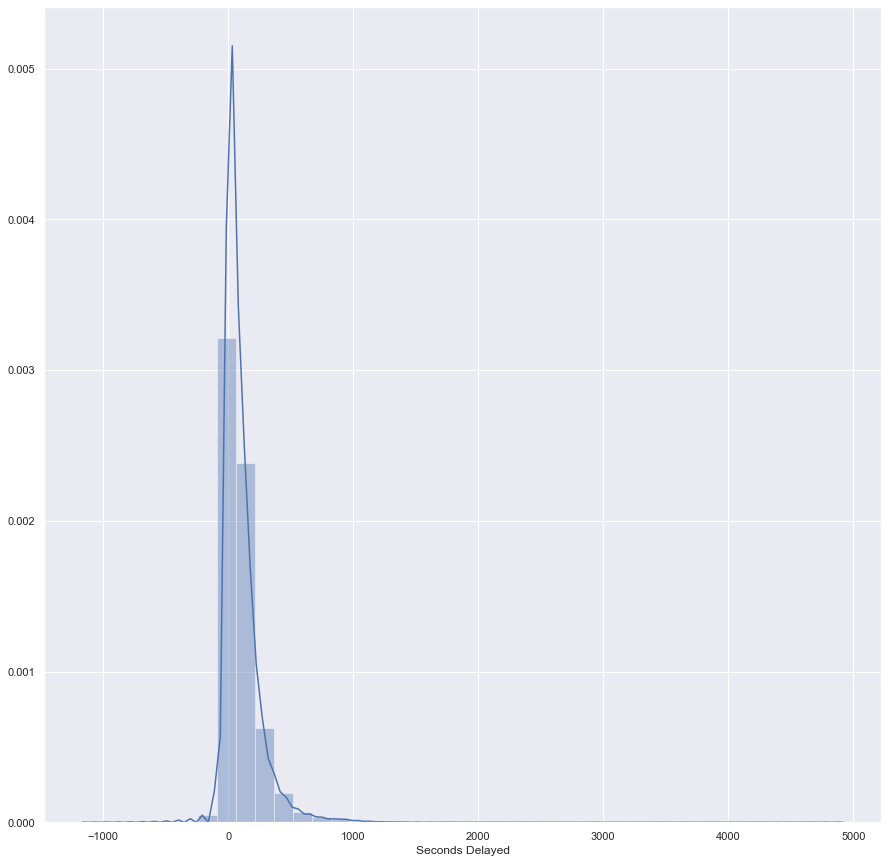

,branch,avg_seconds_delay
0,A,128.472299
1,B,53.716694
2,C,110.373797
3,D,126.189985
4,E,108.776245
5,F,160.507524
6,G,156.038207
7,H,133.933865
8,L,98.247274
9,R,59.326995


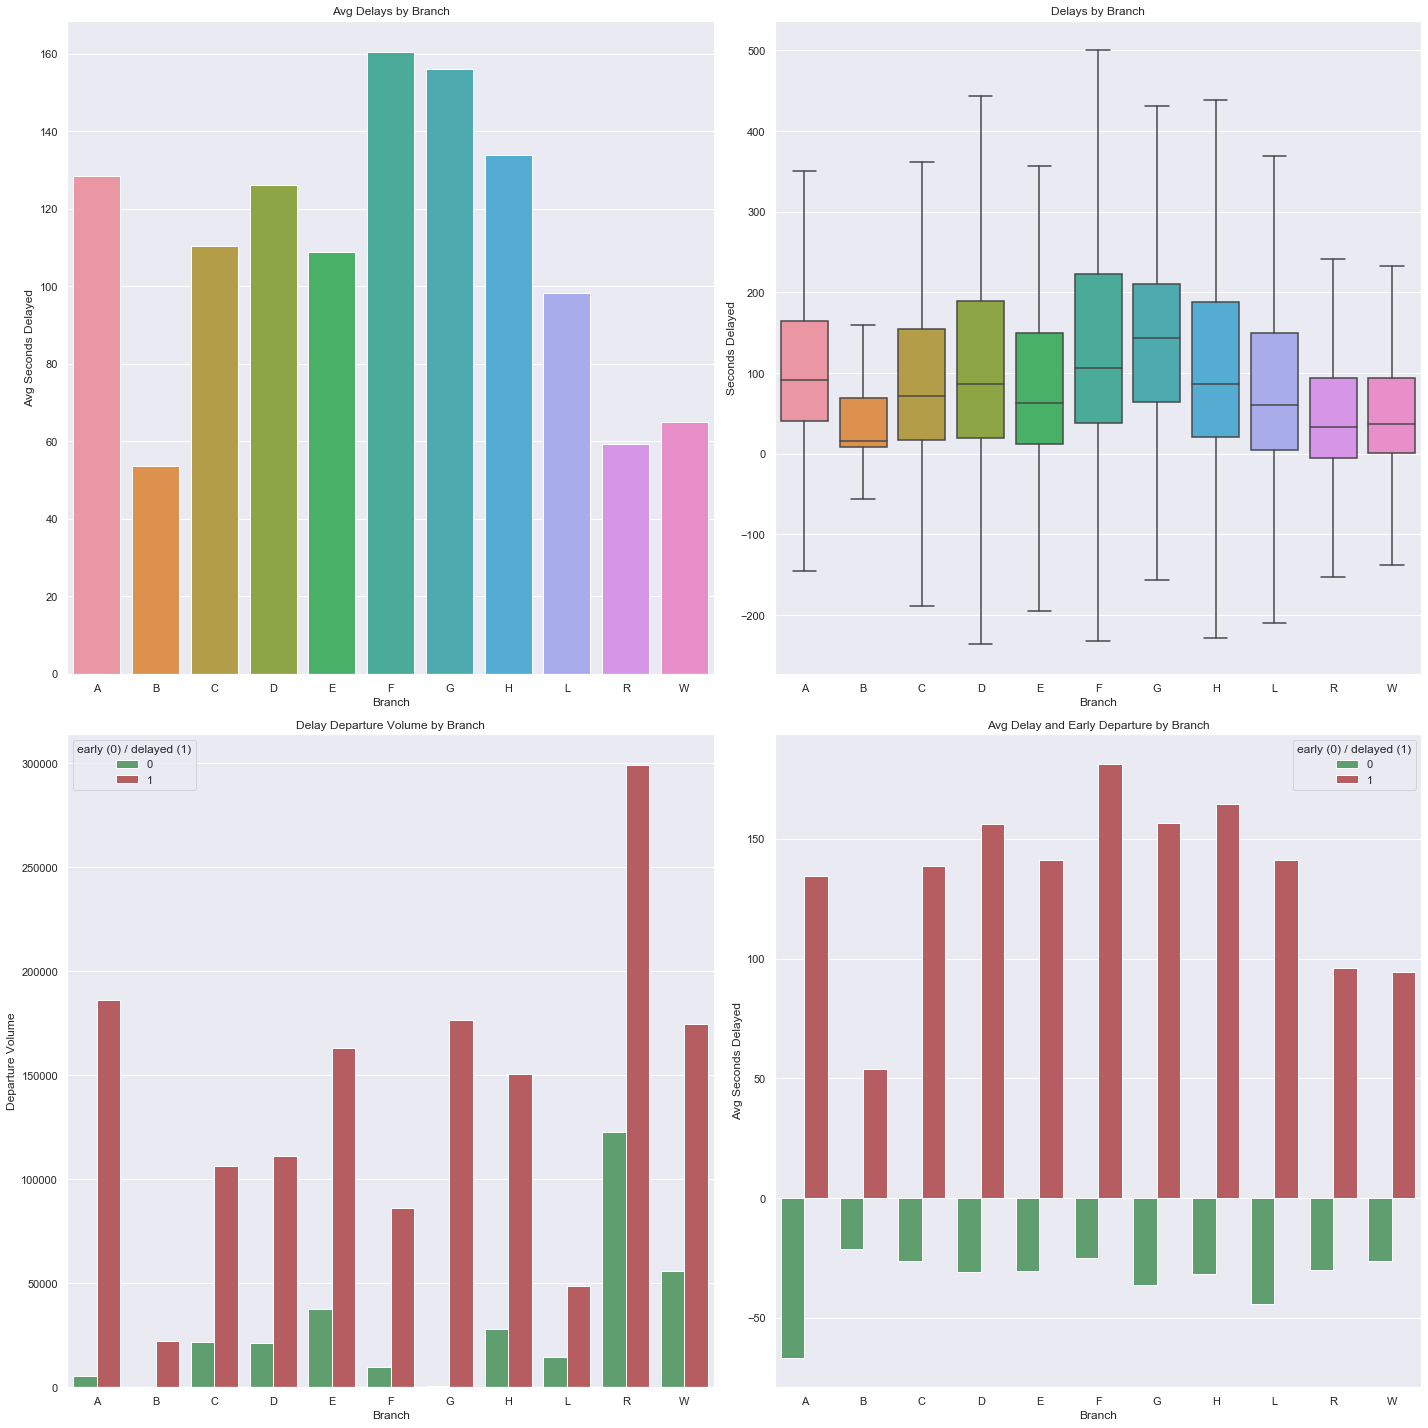

In [160]:
# average train delay
total_mean = trains_games['DEPARTURE_DELAY'].mean()
print('Average seconds delay: ' + str(total_mean))

# percentage of trains with early or late departure
delay_pct = trains_games.DELAYED_FLG.value_counts(normalize=True, sort=False).mul(100)
delay_pct.index.name = 'delayed_departure'
delay_pct.name = 'percentage'
display(delay_pct.to_frame())

plt.figure(figsize=(15,15))
sns.distplot(trains_games['DEPARTURE_DELAY'],
            bins = 40)
plt.xlabel('Seconds Delayed')
plt.show()

# average delayed departure by branch TABLE
branch_mean_delay = trains_games[['BRANCH','DEPARTURE_DELAY']].groupby('BRANCH', as_index=False).mean()
branch_mean_delay.columns=['branch','avg_seconds_delay']
#branch_mean_delay.index.name = 'branch'
display(branch_mean_delay)

# average delayed departure by branch BARCHART
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.barplot(x='branch',
             y='avg_seconds_delay',
             data = branch_mean_delay)
plt.ylabel('Avg Seconds Delayed')
plt.title('Avg Delays by Branch')
plt.xlabel('Branch')


# BOXPLOT view of delayed departures by branch
plt.subplot(2,2,2)
sns.boxplot(x='BRANCH',
             y='DEPARTURE_DELAY',
             data = delays,
             showfliers=False)
plt.ylabel('Seconds Delayed')
plt.xlabel('Branch')
plt.title('Delays by Branch')

# proprotion of each branch's stations that have delayed or on-time/early departure
plt.subplot(2,2,3)
sns.countplot(x='BRANCH',
             data=trains_games.sort_values('BRANCH'),
             hue='DELAYED_FLG', 
             palette={1:'r',
                     0:'g'})
plt.xlabel('Branch')
plt.ylabel('Departure Volume')
plt.title('Delay Departure Volume by Branch')
plt.legend(title='early (0) / delayed (1)')

# average late and early departures by branch
early_late_delay = trains_games[['BRANCH','DEPARTURE_DELAY','DELAYED_FLG']].groupby(['BRANCH','DELAYED_FLG'],as_index=False).mean()
early_late_delay.columns=['branch','delayed_flg','avg_seconds_delay']
early_late_delay.sort_values('branch',inplace=True)
#early_late_delay.delayed_flg = early_late_delay.delayed_flg.map({1:'late',0:'early'})
plt.subplot(2,2,4)
sns.barplot(x='branch',
           y='avg_seconds_delay',
           hue='delayed_flg',
           data=early_late_delay,
           palette={1:'r',
                     0:'g'}
           )
plt.xlabel('Branch')
plt.ylabel('Avg Seconds Delayed')
plt.title('Avg Delay and Early Departure by Branch')
plt.legend(title='early (0) / delayed (1)')
plt.tight_layout()
plt.show()

# Interaction between time of year (seasonality) and delays

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 2 columns):
TIME         12 non-null period[M]
avg_delay    12 non-null float64
dtypes: float64(1), period[M](1)
memory usage: 288.0 bytes


,TIME,avg_delay
0,2018-12,73.389547
1,2019-01,76.560149
2,2019-02,102.216668
3,2019-03,118.347936
4,2019-04,94.195797
5,2019-05,112.319712
6,2019-06,90.899181
7,2019-07,100.789487
8,2019-08,114.212903
9,2019-09,113.502234


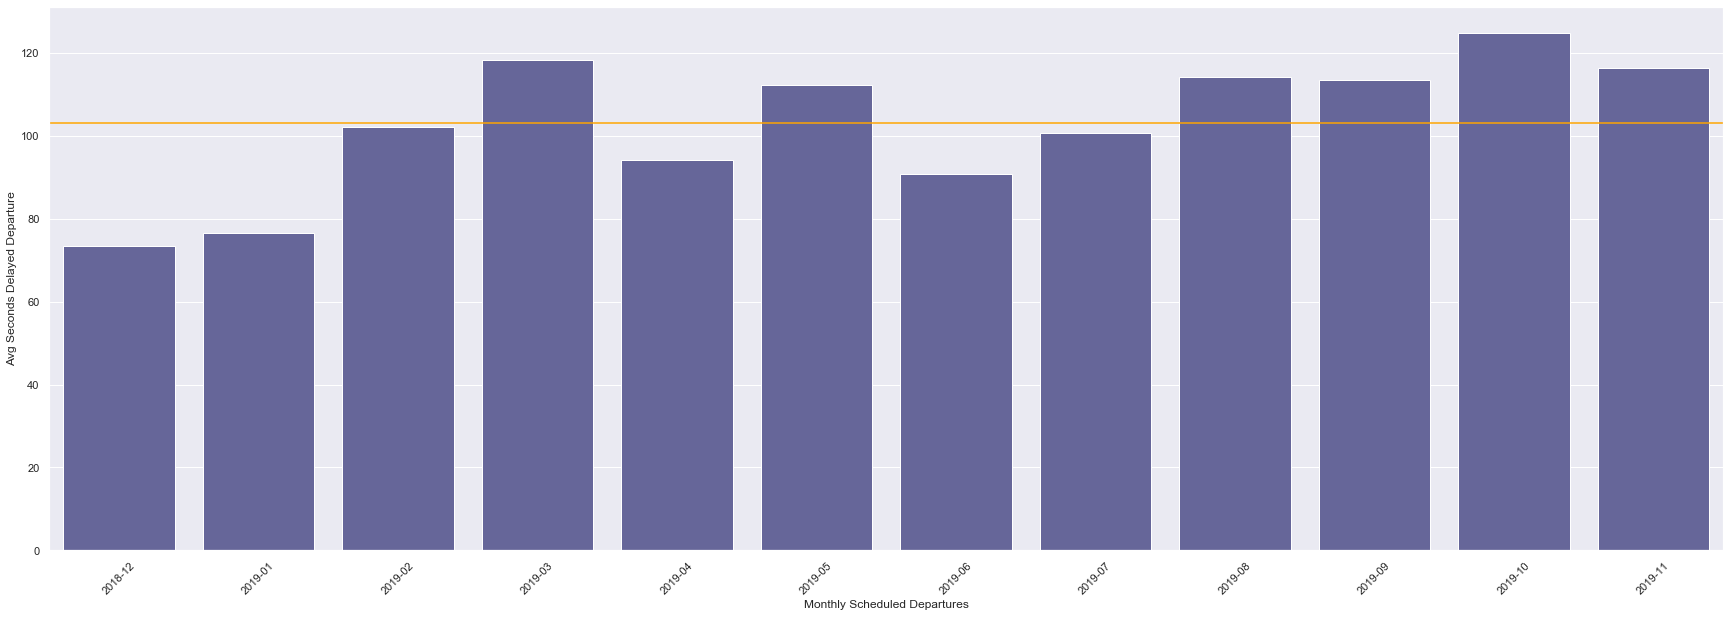

There are approximately 35446 station instances per week in this dataset.


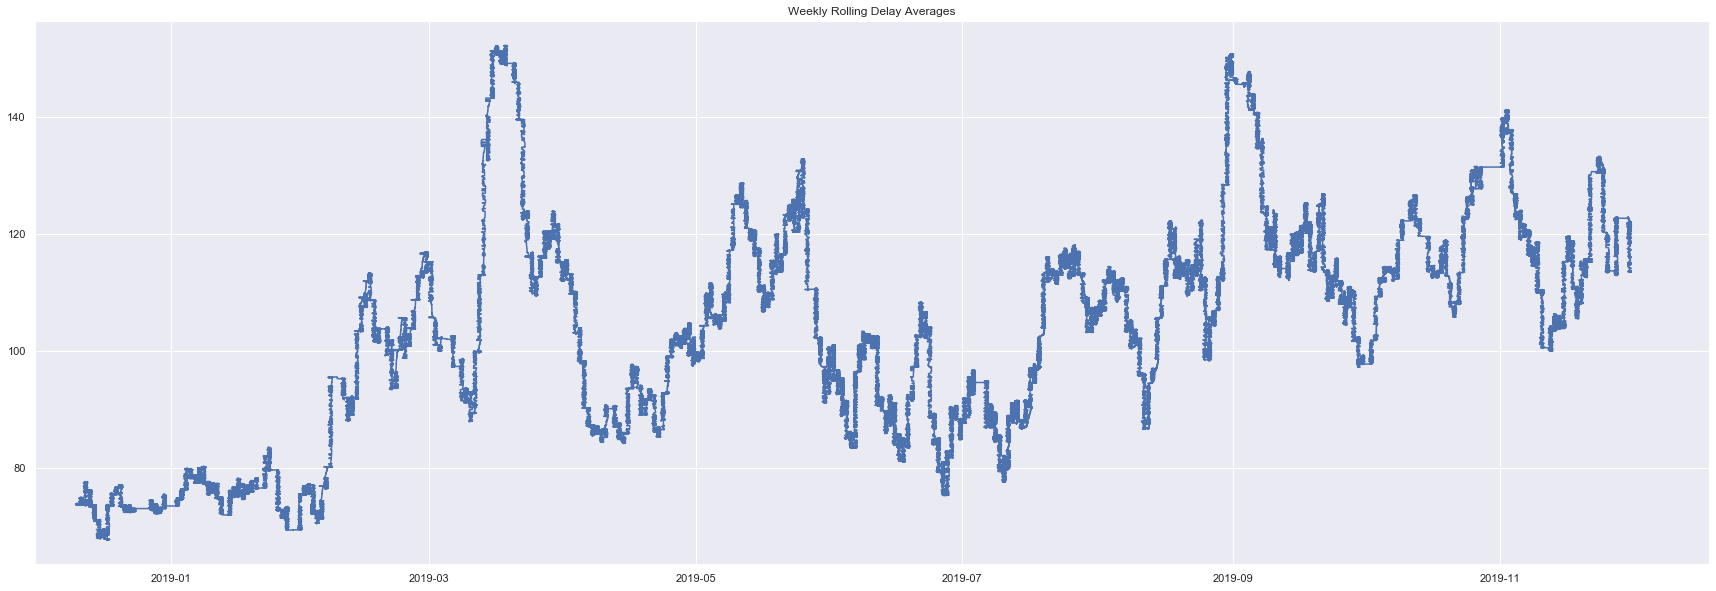

There are approximately 153602 station instances per month in this dataset.


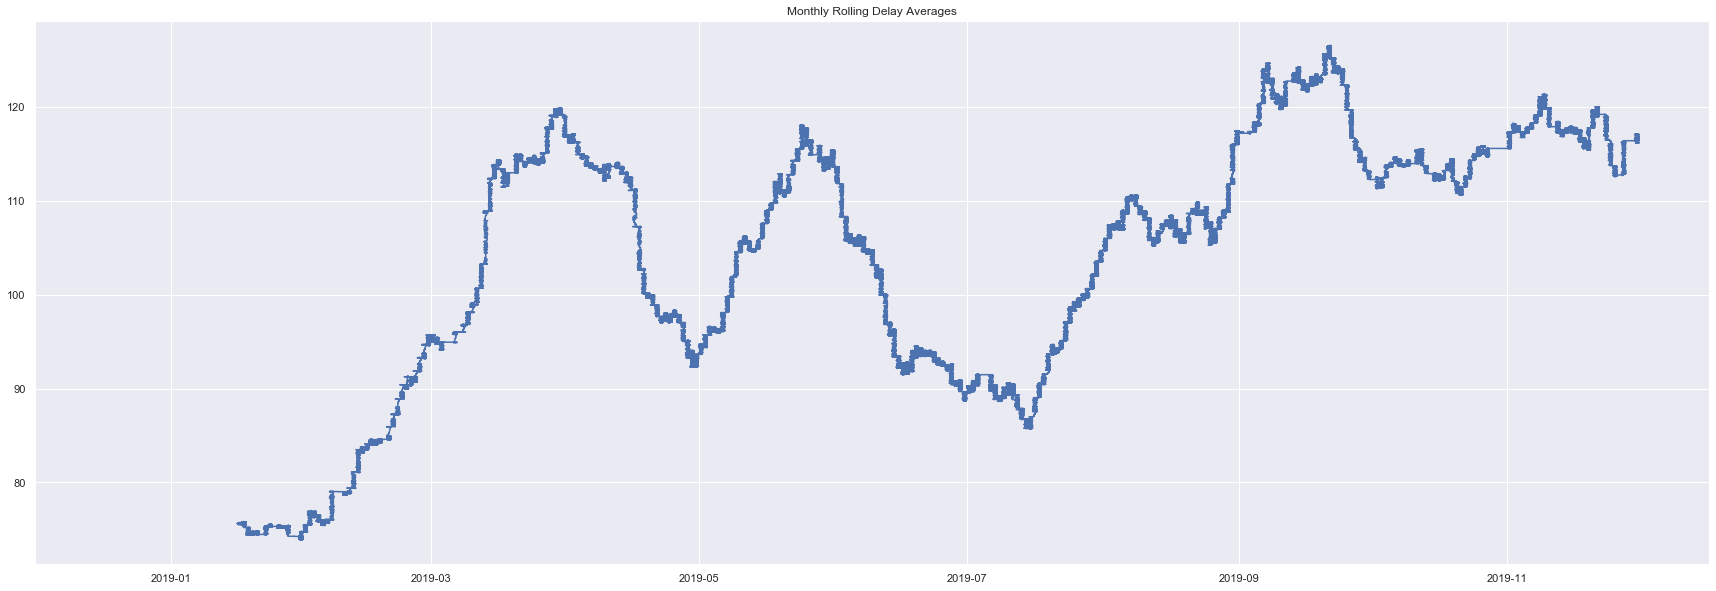

There are approximately 460808 station instances per month in this dataset.


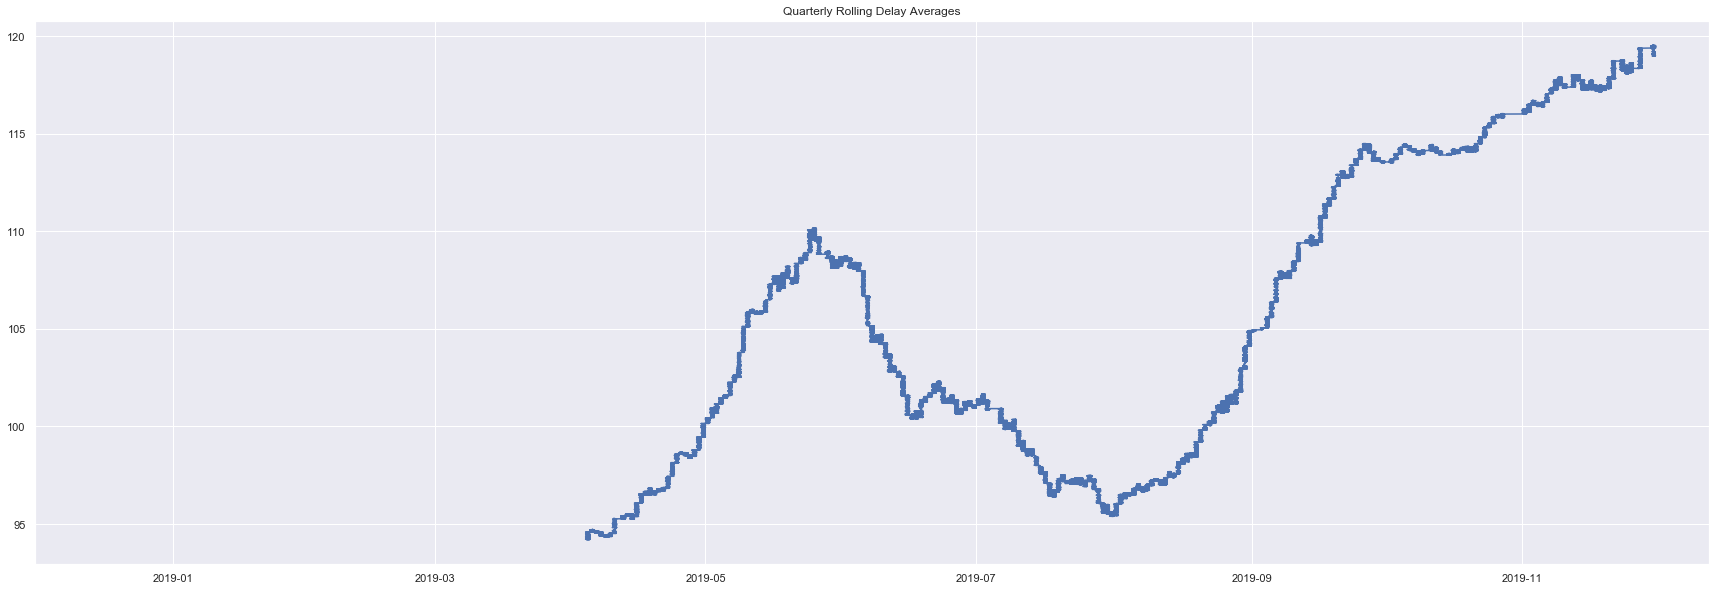

In [161]:
# averaging minutes delay over discrete month
monthly_delays = trains_games[['TIME_SCHEDULED',
                               'DEPARTURE_DELAY']]
monthly_delays.loc[:,'MONTH'] = monthly_delays.TIME_SCHEDULED.dt.month
monthly_delays.loc[:,'YEAR'] = monthly_delays.TIME_SCHEDULED.dt.year
monthly_delays.loc[:,'TIME'] = pd.to_datetime(monthly_delays['YEAR'].astype(str) + monthly_delays['MONTH'].astype(str), format = '%Y%m')
monthly_delays.loc[:,'TIME'] = monthly_delays.TIME.dt.to_period('M')
monthly_delays = monthly_delays[['TIME','DEPARTURE_DELAY']].groupby('TIME',as_index=False).mean()
monthly_delays.columns=['TIME','avg_delay']
#monthly_delays.reset_index()
monthly_delays.info()
display(monthly_delays)
total_avg = monthly_delays.avg_delay.mean()
monthly_delays['total_avg'] = total_avg
# plot discrete monthly delay averages
plt.figure(figsize=(30,10))
sns.barplot(x='TIME', y='avg_delay', data=monthly_delays,
           color='blue',
           saturation=0.2)
plt.xlabel('Monthly Scheduled Departures')
plt.ylabel('Avg Seconds Delayed Departure')
plt.xticks(rotation=45)
plt.axhline(total_avg,
           color='orange')
plt.show()


rolling_delays = trains_games[['TIME_SCHEDULED',
                               'DEPARTURE_DELAY']]
x_min = rolling_delays.TIME_SCHEDULED.min()
# estimate number of records, i.e. stations, per incremental units to view rolling averages and identify possible seasonal trends
row_count = rolling_delays.shape[0]
# weekly rolling averages
print('There are approximately ' + str(int(row_count/52)) + ' station instances per week in this dataset.')
rolling_dep_weekly = rolling_delays.DEPARTURE_DELAY.rolling(window=35446).mean()
plt.figure(figsize=(30,10))
plt.plot(rolling_delays.TIME_SCHEDULED, 
         rolling_dep_weekly)
plt.title('Weekly Rolling Delay Averages')
x1,x2,y1,y2 = plt.axis()
plt.axis((x_min,x2,y1,y2))
plt.show()

# monthly rolling averages
print('There are approximately ' + str(int(row_count/12)) + ' station instances per month in this dataset.')
rolling_dep_weekly = rolling_delays.DEPARTURE_DELAY.rolling(window=153602).mean()
plt.figure(figsize=(30,10))
plt.plot(rolling_delays.TIME_SCHEDULED, 
         rolling_dep_weekly)
plt.title('Monthly Rolling Delay Averages')
x1,x2,y1,y2 = plt.axis()
plt.axis((x_min,x2,y1,y2))
plt.show()

# quarterly rolling averages
print('There are approximately ' + str(int(row_count/4)) + ' station instances per month in this dataset.')
rolling_dep_weekly = rolling_delays.DEPARTURE_DELAY.rolling(window=460808).mean()
plt.figure(figsize=(30,10))
plt.plot(rolling_delays.TIME_SCHEDULED, 
         rolling_dep_weekly)
plt.title('Quarterly Rolling Delay Averages')
x1,x2,y1,y2 = plt.axis()
plt.axis((x_min,x2,y1,y2))
plt.show()

In [162]:
# Direction, Branch and Station Performance

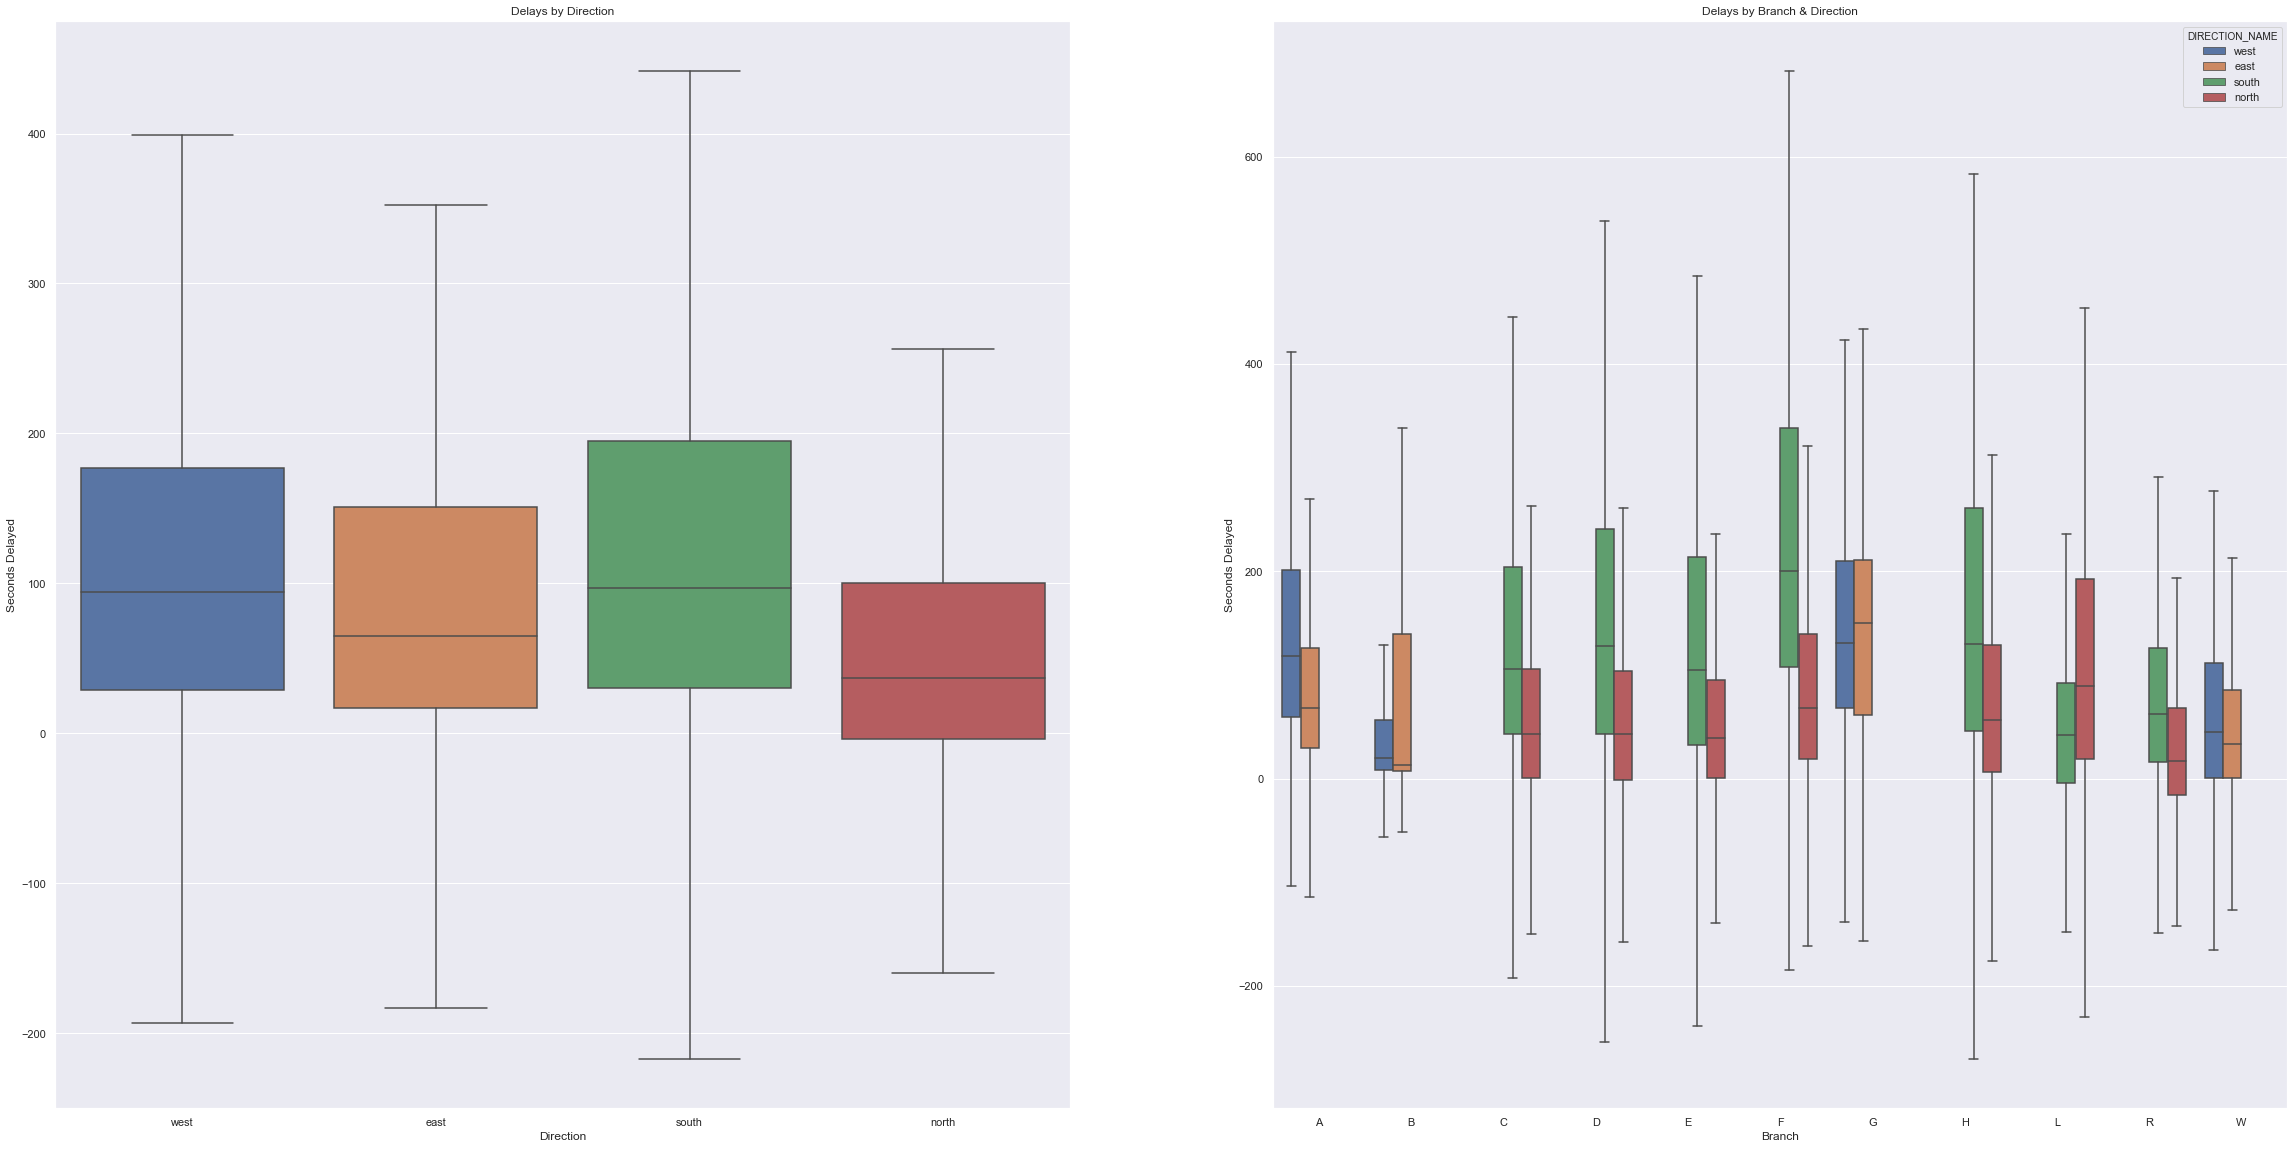

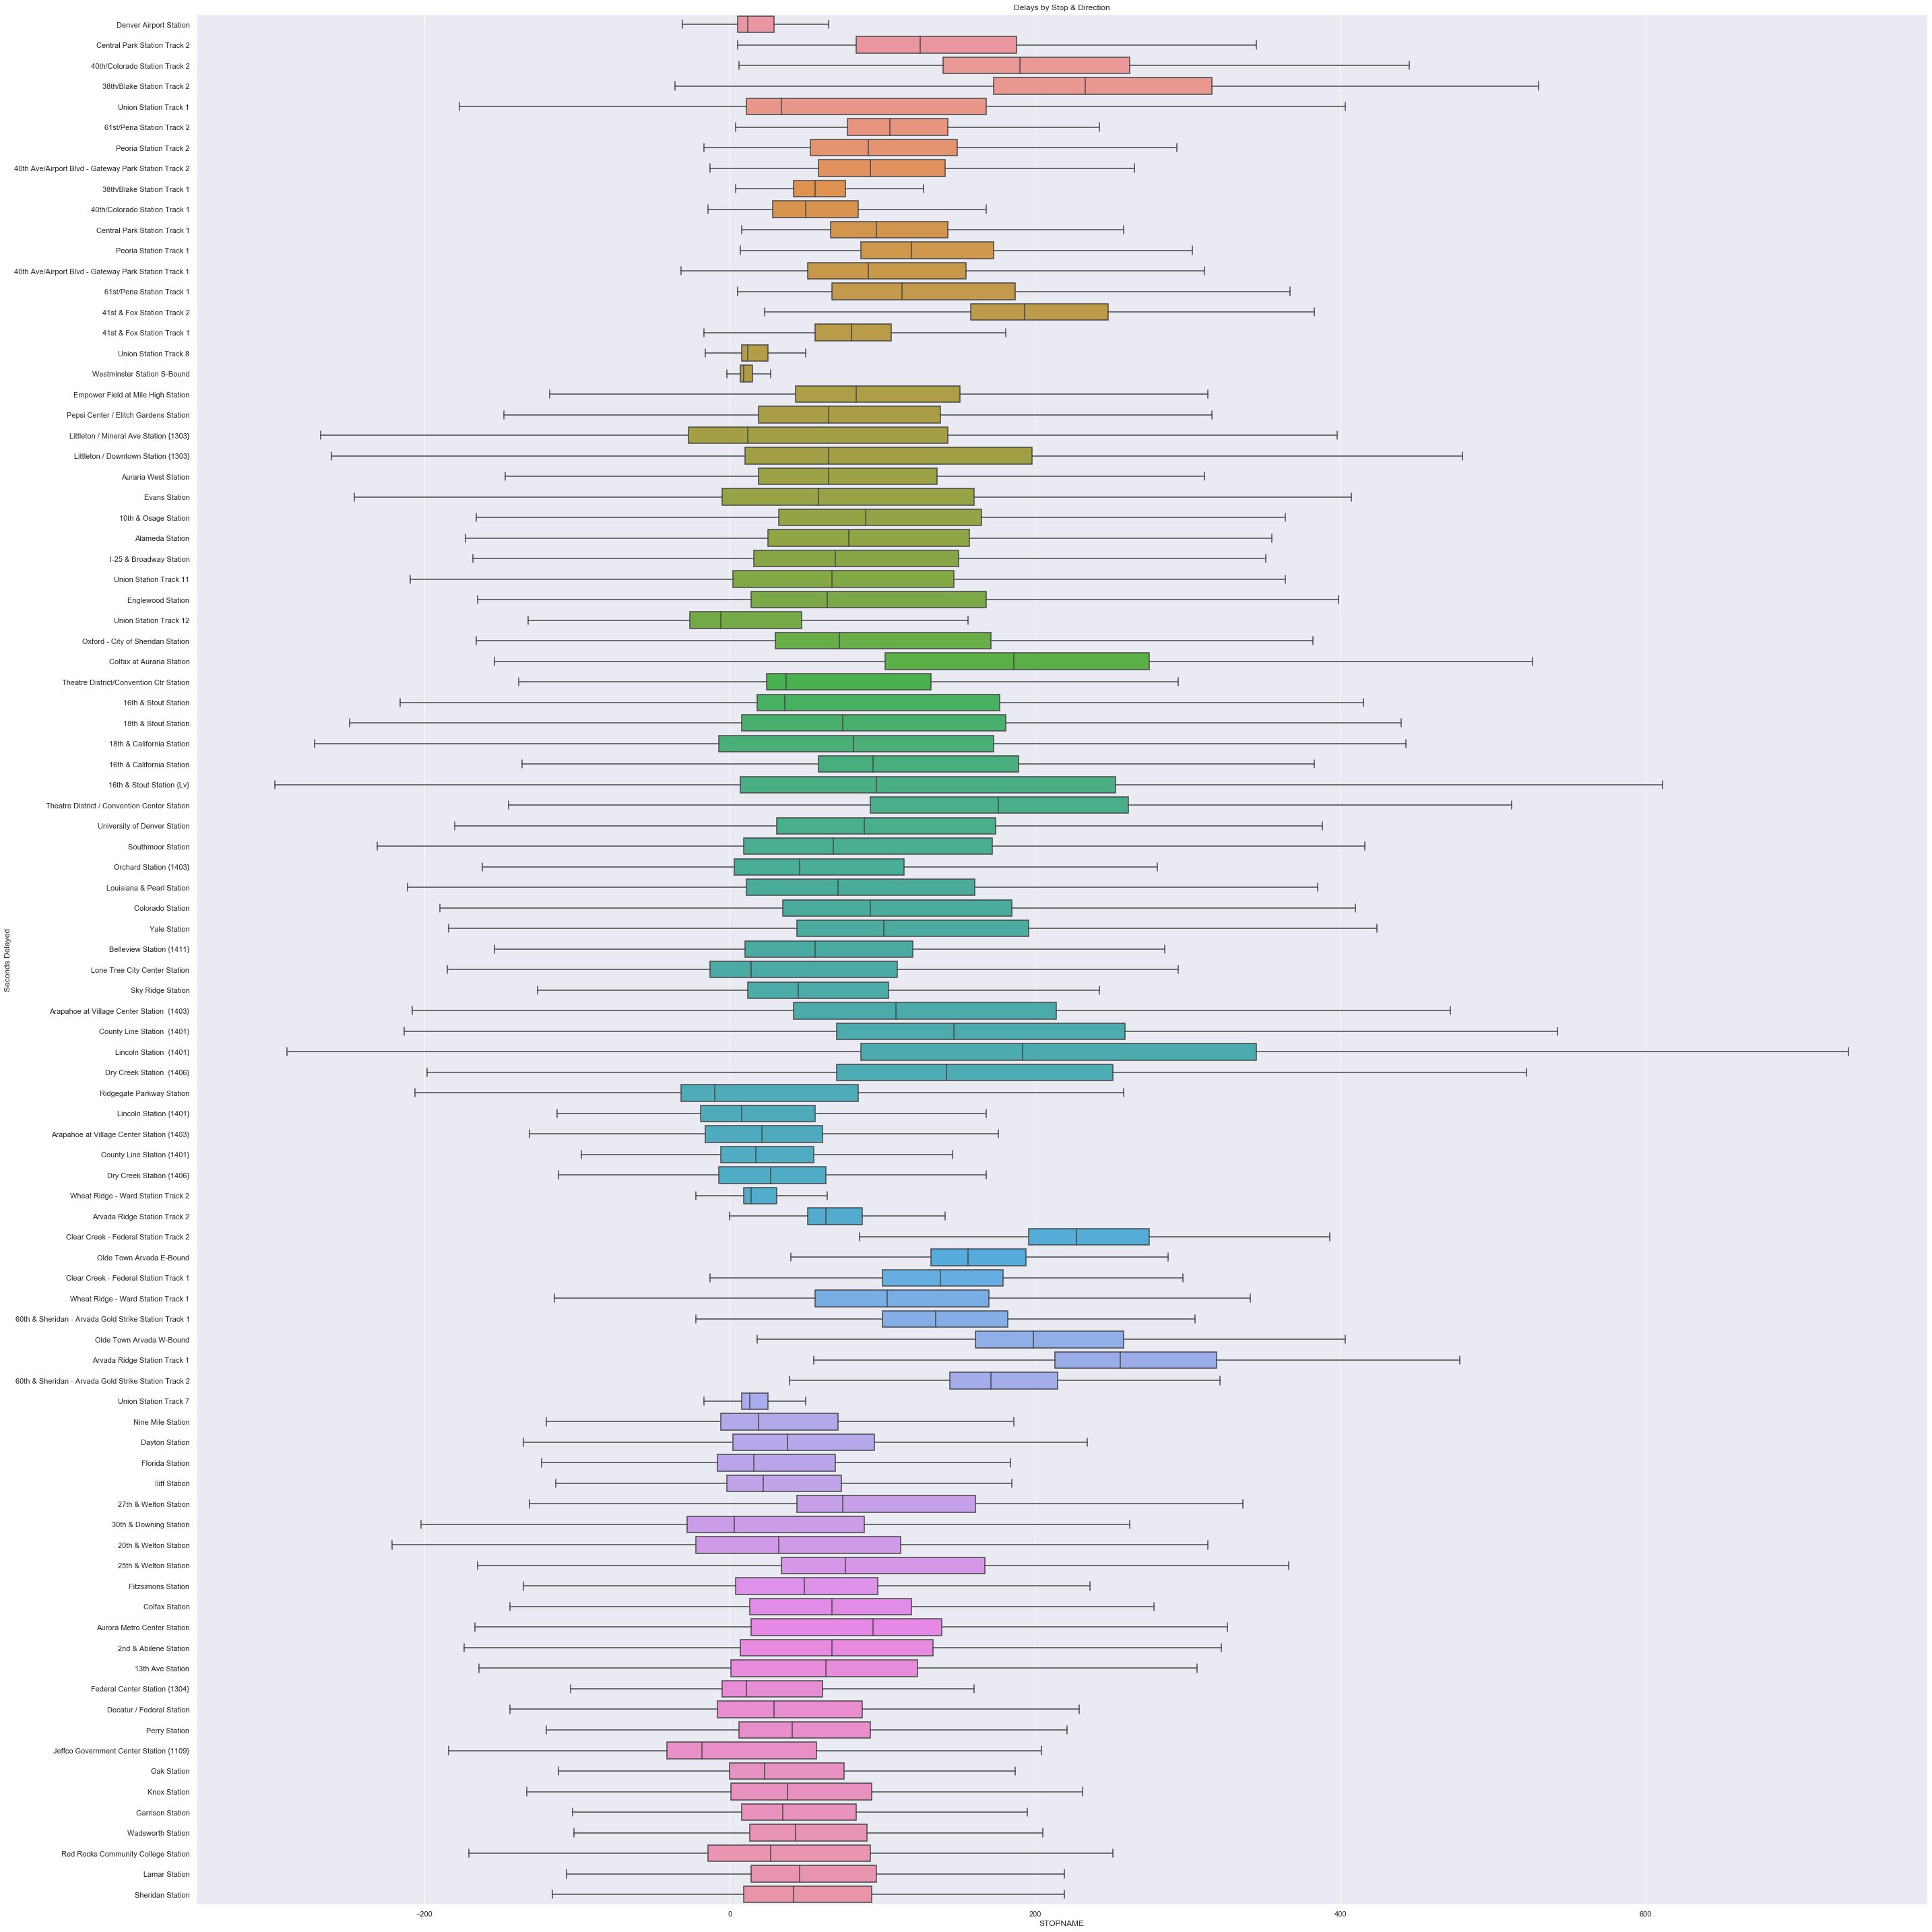

In [163]:
plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
sns.boxplot(x='DIRECTION_NAME',
             y='DEPARTURE_DELAY',
             data = delays,
             showfliers=False)
plt.ylabel('Seconds Delayed')
plt.xlabel('Direction')
plt.title('Delays by Direction')

plt.subplot(1,2,2)
sns.boxplot(x='BRANCH',
             y='DEPARTURE_DELAY',
             hue = 'DIRECTION_NAME',
             data = delays,
             showfliers=False)
plt.ylabel('Seconds Delayed')
plt.xlabel('Branch')
plt.title('Delays by Branch & Direction')
##plt.tight_layout()
plt.show()

plt.figure(figsize=(40,40))
sns.boxplot(y='STOPNAME',
             x='DEPARTURE_DELAY',
             data = delays,
             orient ="h",
             showfliers=False)
plt.ylabel('Seconds Delayed')
plt.xlabel('STOPNAME')
plt.title('Delays by Stop & Direction')
#plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

# Evaluation of previous delays' affects on current delay

In [168]:
def PRIOR_DELAY(df,delay,key,shift):
    """Returns dataframe and correlation of previous (n) station's delay and current delay
    
    Parameters:
       df: train station data that must include BRANCH, DIRECTION_NAME, SORT_ORDER, TIME_SCHEDULED, STOPNAME, TRIP_KEY, (derived) DEPARTURE_DELAY
       delay: (derived) DEPARTURE_DELAY
       key: (native) TRIP_KEY
       shift: represents n stations in past"""  
    
    
    prior_delay = df[['BRANCH',
                               'DIRECTION_NAME',
                               'SORT_ORDER',
                               'TIME_SCHEDULED',
                               'STOPNAME',
                               'TRIP_KEY',
                               'DEPARTURE_DELAY']].sort_values(by=['BRANCH','DIRECTION_NAME','TRIP_KEY','TIME_SCHEDULED','SORT_ORDER']).reset_index()
    """Provided dataframe will be reduced to required fields and sorted and re-indexed to ensure stations are in chronological order by BRANCH, DIRECTION, TRIP, and SCHEDULE."""
    prior_delay.drop('index',axis=1,inplace=True)
    
    """Function to create new dataframe with 2 new columns for n station's delay and trip key and remove all rows that do not have corresponding nth station."""
    new_fields=[]
    prev_delay=delay+'_'+str(shift)
    prev_key=key+'_'+str(shift)
    new_fields.append(prev_delay)
    new_fields.append(prev_key)
    prior_delay[new_fields] = prior_delay[[delay,key]].shift(shift)
    incorrect_match = prior_delay.loc[prior_delay[key] != prior_delay[prev_key]].index
    prior_delay = prior_delay.drop(incorrect_match,axis=0)
    
    sns.jointplot(x=prev_delay,
              y=delay,
              data=prior_delay,
              kind='kde',
              height=8).annotate(stats.pearsonr)
    plt.ylabel('Current Departure Delay')
    plt.xlabel('Delay at Previous ' + str(shift) + ' Station')
    plt.title('Current Delay v. Prior ' + str(shift) + ' Delay')

In [ ]:
PRIOR_DELAY(trains_games,'DEPARTURE_DELAY','TRIP_KEY',1)
#PRIOR_DELAY(trains_games,'DEPARTURE_DELAY','TRIP_KEY',2)
#PRIOR_DELAY(trains_games,'DEPARTURE_DELAY','TRIP_KEY',3)
#PRIOR_DELAY(trains_games,'DEPARTURE_DELAY','TRIP_KEY',4)
plt.tight_layout()
plt.show()